# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns 

from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score, 
    confusion_matrix, precision_score, recall_score, log_loss, brier_score_loss, balanced_accuracy_score, f1_score
)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from venn_abers import VennAbersCalibrator
from xgboost import XGBClassifier

from mapie.metrics.calibration import expected_calibration_error

# Helper Functions

In [205]:
def model_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        "ROC_AUC": round(roc_auc_score(y_true, y_prob), 3),
        "Balanced_Accuracy": round(balanced_accuracy_score(y_true, y_pred), 3),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 3),
        "F1": round(f1_score(y_true, y_pred, zero_division=0), 3),
        "LogLoss": round(log_loss(y_true, y_prob), 3),
    }

    return metrics

def calibration_metrics(y_true, y_proba, method_name, split_strategy='uniform'):
    logloss = round(log_loss(y_true, y_proba),3)
    brier   = round(brier_score_loss(y_true, y_proba),3)
    ece = round(expected_calibration_error(y_true, y_proba, num_bins=10, split_strategy=split_strategy),3)
    return {"Method": method_name, "Log Loss": logloss, "Brier Score": brier, "ECE": ece}

# Data Preparation for Modeling

In [3]:
TRAIN_PATH = "DATA/preprocessed_train.csv"
VALID_PATH = "DATA/preprocessed_valid.csv"
TEST_PATH  = "DATA/preprocessed_test.csv"

In [4]:
df_tr = pd.read_csv(TRAIN_PATH)
df_va = pd.read_csv(VALID_PATH)
df_te = pd.read_csv(TEST_PATH)

In [5]:
TARGET = "loan_status"
ID_COL = "ID"

X_tr = df_tr.drop(columns=[TARGET, ID_COL])
y_tr = df_tr[TARGET]

X_va = df_va.drop(columns=[TARGET, ID_COL])
y_va = df_va[TARGET]  

X_te = df_te.drop(columns=[TARGET, ID_COL])
y_te = df_te[TARGET]

# XGBoost Model Training

In [6]:
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / max(pos, 1)  

xgb_model = XGBClassifier(
    n_estimators=50,        
    learning_rate=0.1,
    max_depth=7,
    random_state=42
)

In [7]:
xgb_model.fit(
    X_tr, y_tr
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


# Predictions

In [8]:
proba_tr = xgb_model.predict_proba(X_tr)[:, 1]
proba_va = xgb_model.predict_proba(X_va)[:, 1]
proba_te = xgb_model.predict_proba(X_te)[:, 1]

In [9]:
print('Train Metrics:')
print(model_metrics(y_tr, proba_tr, threshold=0.5))

print('Validation Metrics:')
print(model_metrics(y_va, proba_va, threshold=0.5))

print('Test Metrics:')
print(model_metrics(y_te, proba_te, threshold=0.5))

Train Metrics:
{'ROC_AUC': 0.956, 'Balanced_Accuracy': 0.854, 'Precision': 0.985, 'Recall': 0.711, 'F1': 0.826, 'LogLoss': 0.187}
Validation Metrics:
{'ROC_AUC': 0.942, 'Balanced_Accuracy': 0.858, 'Precision': 0.98, 'Recall': 0.72, 'F1': 0.83, 'LogLoss': 0.194}
Test Metrics:
{'ROC_AUC': 0.938, 'Balanced_Accuracy': 0.849, 'Precision': 0.984, 'Recall': 0.7, 'F1': 0.818, 'LogLoss': 0.203}


In [10]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(y_te, y_pred)

# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=["Pred 0", "Pred 1"],
#             yticklabels=["True 0", "True 1"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix (Test Set)")
# plt.show()

## Feature Importance Plot

In [11]:
feature_importances = pd.DataFrame(xgb_model.feature_importances_, columns=["Importance"], index=X_tr.columns).reset_index(names="Features").sort_values(by="Importance", ascending=False)

In [12]:
feature_importances

,Features,Importance
4,loan_grade,0.341828
6,loan_percent_income,0.260747
1,person_home_ownership,0.178550
3,loan_intent,0.074913
0,person_income,0.060847
2,person_emp_length,0.049140
5,loan_amnt,0.012319
8,cb_person_cred_hist_length,0.011055
7,cb_person_default_on_file,0.010602


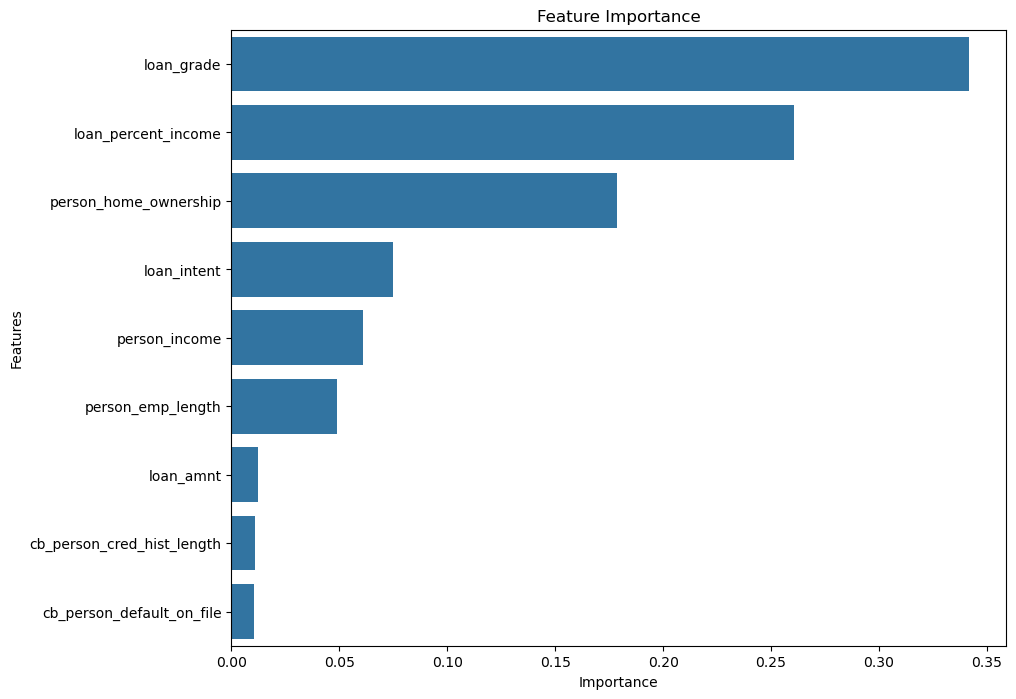

In [13]:
# plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances, x="Importance", y="Features")
plt.title("Feature Importance")
plt.show()

# Calibration

## Platt Calibration

In [14]:
# --- 1) Prefit calibration models (validation set) ---
platt = CalibratedClassifierCV(estimator=xgb_model, method="sigmoid", cv="prefit")
platt.fit(X_va, y_va)

c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


,estimator,"XGBClassifier...ree=None, ...)"
,method,'sigmoid'
,cv,'prefit'
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [15]:
proba_tr_platt = platt.predict_proba(X_tr)[:, 1]
proba_va_platt = platt.predict_proba(X_va)[:, 1]
proba_te_platt = platt.predict_proba(X_te)[:, 1]

In [16]:
print('Tra:', model_metrics(y_tr, proba_tr_platt, threshold=0.5))

print('Val:', model_metrics(y_va, proba_va_platt, threshold=0.5))

print('Tes:', model_metrics(y_te, proba_te_platt, threshold=0.5))

Tra: {'ROC_AUC': 0.956, 'Balanced_Accuracy': 0.863, 'Precision': 0.974, 'Recall': 0.731, 'F1': 0.835, 'LogLoss': 0.189}
Val: {'ROC_AUC': 0.942, 'Balanced_Accuracy': 0.866, 'Precision': 0.968, 'Recall': 0.738, 'F1': 0.838, 'LogLoss': 0.198}
Tes: {'ROC_AUC': 0.938, 'Balanced_Accuracy': 0.853, 'Precision': 0.967, 'Recall': 0.714, 'F1': 0.821, 'LogLoss': 0.207}


In [17]:
print('Tra', calibration_metrics(y_tr, proba_tr_platt, "Platt Scaling"))
print('Val', calibration_metrics(y_va, proba_va_platt, "Platt Scaling"))
print('Tes', calibration_metrics(y_te, proba_te_platt, "Platt Scaling"))

Tra {'Method': 'Platt Scaling', 'Log Loss': 0.189, 'Brier Score': 0.052, 'ECE': 0.017}
Val {'Method': 'Platt Scaling', 'Log Loss': 0.198, 'Brier Score': 0.053, 'ECE': 0.006}
Tes {'Method': 'Platt Scaling', 'Log Loss': 0.207, 'Brier Score': 0.057, 'ECE': 0.008}


## Isotonic Calibration

In [18]:
isotonic = CalibratedClassifierCV(estimator=xgb_model, method="isotonic", cv="prefit")
isotonic.fit(X_va, y_va)

c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,'prefit'
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [19]:
proba_tr_iso = isotonic.predict_proba(X_tr)[:, 1]
proba_va_iso = isotonic.predict_proba(X_va)[:, 1]
proba_te_iso = isotonic.predict_proba(X_te)[:, 1]

In [20]:
print('Tra:', model_metrics(y_tr, proba_tr_iso, threshold=0.5))

print('Val:', model_metrics(y_va, proba_va_iso, threshold=0.5))

print('Tes:', model_metrics(y_te, proba_te_iso, threshold=0.5))

Tra: {'ROC_AUC': 0.956, 'Balanced_Accuracy': 0.864, 'Precision': 0.972, 'Recall': 0.734, 'F1': 0.836, 'LogLoss': 0.194}
Val: {'ROC_AUC': 0.944, 'Balanced_Accuracy': 0.868, 'Precision': 0.965, 'Recall': 0.743, 'F1': 0.839, 'LogLoss': 0.183}
Tes: {'ROC_AUC': 0.937, 'Balanced_Accuracy': 0.854, 'Precision': 0.963, 'Recall': 0.716, 'F1': 0.821, 'LogLoss': 0.267}


In [21]:
print('Tra:', calibration_metrics(y_tr, proba_tr_iso, "Isotonic Regression"))
print('Val:', calibration_metrics(y_va, proba_va_iso, "Isotonic Regression"))
print('Tes:', calibration_metrics(y_te, proba_te_iso, "Isotonic Regression"))

Tra: {'Method': 'Isotonic Regression', 'Log Loss': 0.194, 'Brier Score': 0.052, 'ECE': 0.016}
Val: {'Method': 'Isotonic Regression', 'Log Loss': 0.183, 'Brier Score': 0.052, 'ECE': 0.0}
Tes: {'Method': 'Isotonic Regression', 'Log Loss': 0.267, 'Brier Score': 0.056, 'ECE': 0.011}


## Venn-ABERS calibration

### Inductive

In [22]:
p_train = xgb_model.predict_proba(X_tr)
p_cal = xgb_model.predict_proba(X_va)
p_test = xgb_model.predict_proba(X_te)

In [23]:
VAC = VennAbersCalibrator()
proba_tr_iva, intervals_tr_iva = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_train, p0_p1_output=True)
proba_val_iva, intervals_val_iva = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_cal, p0_p1_output=True)
proba_test_iva, proba_te_iva = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_test, p0_p1_output=True)

In [24]:
proba_tr_iva = proba_tr_iva[:,1]
proba_val_iva = proba_val_iva[:,1]
proba_te_iva = proba_test_iva[:,1]

In [25]:
print('Tra:', model_metrics(y_tr, proba_tr_iva, 0.5))
print('Val:', model_metrics(y_va, proba_val_iva, 0.5))
print('Tes:', model_metrics(y_te, proba_te_iva, 0.5))

Tra: {'ROC_AUC': 0.956, 'Balanced_Accuracy': 0.864, 'Precision': 0.972, 'Recall': 0.733, 'F1': 0.836, 'LogLoss': 0.182}
Val: {'ROC_AUC': 0.943, 'Balanced_Accuracy': 0.867, 'Precision': 0.967, 'Recall': 0.741, 'F1': 0.839, 'LogLoss': 0.186}
Tes: {'ROC_AUC': 0.938, 'Balanced_Accuracy': 0.854, 'Precision': 0.963, 'Recall': 0.715, 'F1': 0.821, 'LogLoss': 0.201}


In [26]:
print('Tra:', calibration_metrics(y_tr, proba_tr_iva, "Inductive Venn-ABERS"))
print('Val:', calibration_metrics(y_va, proba_val_iva, "Inductive Venn-ABERS"))
print('Tes:', calibration_metrics(y_te, proba_te_iva, "Inductive Venn-ABERS"))

Tra: {'Method': 'Inductive Venn-ABERS', 'Log Loss': 0.182, 'Brier Score': 0.052, 'ECE': 0.017}
Val: {'Method': 'Inductive Venn-ABERS', 'Log Loss': 0.186, 'Brier Score': 0.052, 'ECE': 0.005}
Tes: {'Method': 'Inductive Venn-ABERS', 'Log Loss': 0.201, 'Brier Score': 0.056, 'ECE': 0.008}


### Cross Venn-ABERS

In [56]:
# combine training and validation for cross Venn-ABERS

X_cvap = pd.concat([X_tr, X_va], axis=0, ignore_index=True)
y_cvap = pd.concat([y_tr, y_va], axis=0, ignore_index=True)

In [57]:
# --- CVAP (cross Venn–Abers) ---
va_cross = VennAbersCalibrator(
    estimator=XGBClassifier(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=7,
        random_state=42
    ),
    inductive=False,
    n_splits=5,   
    random_state=42
)

In [58]:
va_cross.fit(X_cvap, y_cvap)
# va_cross.fit(X_tr, y_tr)

In [59]:
proba_train_cva, intervals_tr_cva = va_cross.predict_proba(X_tr, p0_p1_output=True)
proba_val_cva, intervals_val_cva = va_cross.predict_proba(X_va, p0_p1_output=True)
proba_test_cva, intervals_te_cva = va_cross.predict_proba(X_te, p0_p1_output=True)

In [60]:
proba_tr_cva = proba_train_cva[:,1]
proba_val_cva = proba_val_cva[:,1]
proba_te_cva = proba_test_cva[:,1]

In [61]:
# print model performance
print('Tra:', model_metrics(y_tr, proba_tr_cva, 0.5))
print('Val:', model_metrics(y_va, proba_val_cva, 0.5))
print('Test:', model_metrics(y_te, proba_te_cva, 0.5))  

Tra: {'ROC_AUC': 0.952, 'Balanced_Accuracy': 0.855, 'Precision': 0.982, 'Recall': 0.714, 'F1': 0.826, 'LogLoss': 0.187}
Val: {'ROC_AUC': 0.959, 'Balanced_Accuracy': 0.868, 'Precision': 0.988, 'Recall': 0.739, 'F1': 0.845, 'LogLoss': 0.172}
Test: {'ROC_AUC': 0.938, 'Balanced_Accuracy': 0.851, 'Precision': 0.981, 'Recall': 0.707, 'F1': 0.822, 'LogLoss': 0.199}


In [62]:
# print calibration performance
print('Tra:', calibration_metrics(y_tr, proba_tr_cva, "Cross Venn-ABERS"))
print('Val:', calibration_metrics(y_va, proba_val_cva, "Cross Venn-ABERS"))
print('Test:', calibration_metrics(y_te, proba_te_cva, "Cross Venn-ABERS"))

Tra: {'Method': 'Cross Venn-ABERS', 'Log Loss': 0.187, 'Brier Score': 0.053, 'ECE': 0.017}
Val: {'Method': 'Cross Venn-ABERS', 'Log Loss': 0.172, 'Brier Score': 0.048, 'ECE': 0.019}
Test: {'Method': 'Cross Venn-ABERS', 'Log Loss': 0.199, 'Brier Score': 0.056, 'ECE': 0.009}


# Comparison of Calibrations


Calibration Performance (Test Set):


,Log Loss,Brier Score,ECE
Method,,,
Raw (Uncalibrated),0.203,0.056,0.012
Platt Scaling,0.207,0.057,0.008
Isotonic Regression,0.267,0.056,0.011
Venn-Abers (IVAP),0.201,0.056,0.008
Venn-Abers (CVAP),0.199,0.056,0.009


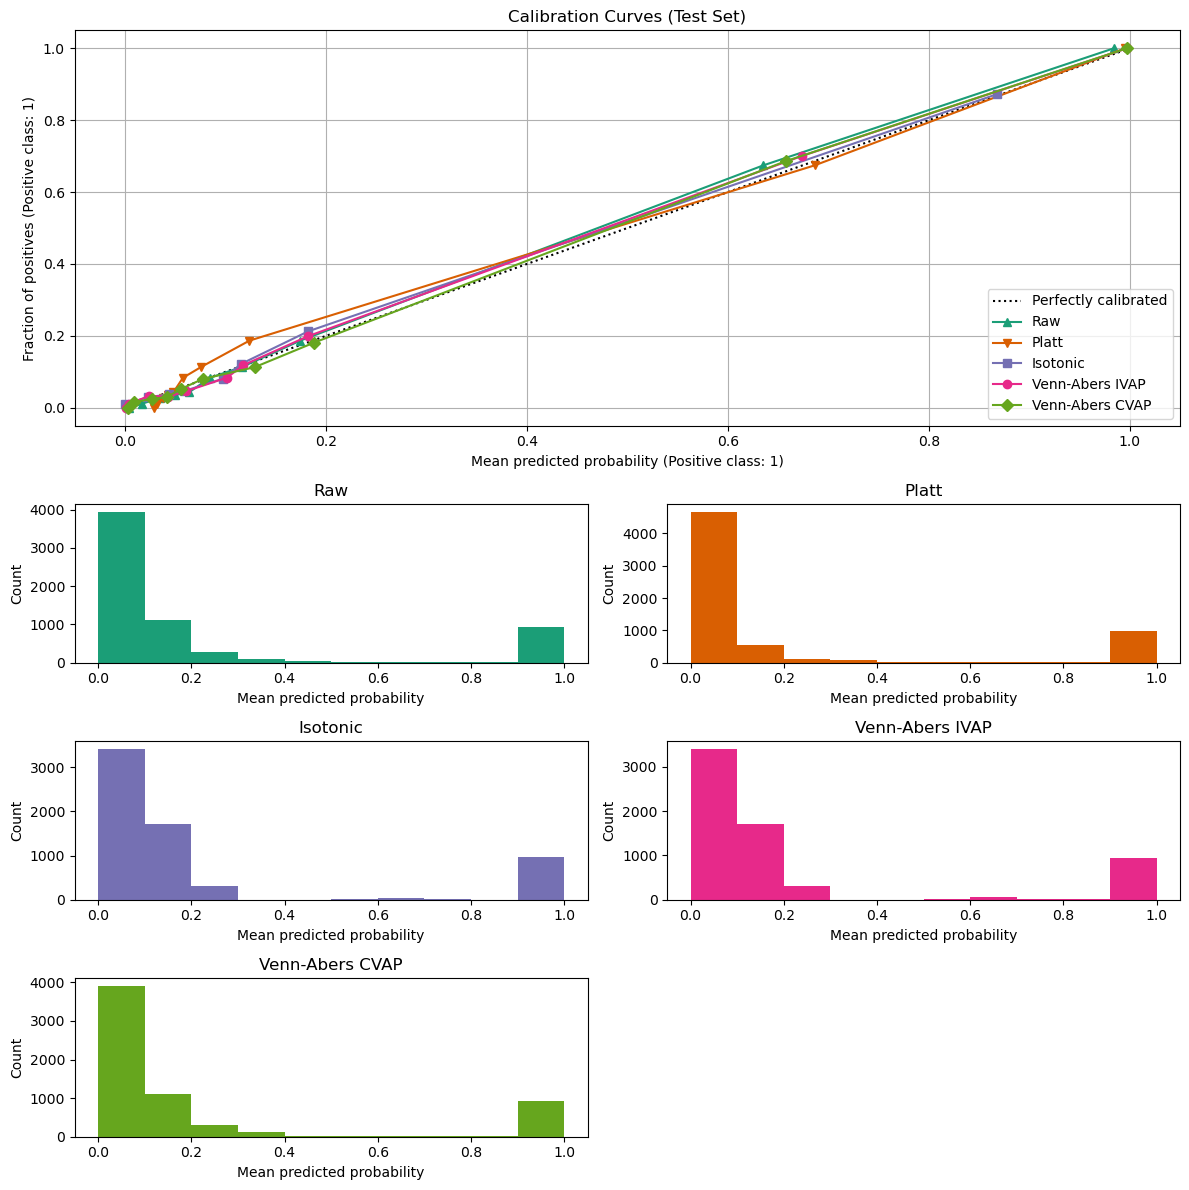

In [101]:
#######################################################################################
############################# Test Set ################################################
#######################################################################################

results = []
results.append(calibration_metrics(y_te, proba_te,      "Raw (Uncalibrated)"))
results.append(calibration_metrics(y_te, proba_te_platt,    "Platt Scaling"))
results.append(calibration_metrics(y_te, proba_te_iso,      "Isotonic Regression"))
results.append(calibration_metrics(y_te, proba_te_iva,       "Venn-Abers (IVAP)"))
results.append(calibration_metrics(y_te, proba_te_cva,     "Venn-Abers (CVAP)"))

calib_df = pd.DataFrame(results).set_index("Method").round(4)
print("\nCalibration Performance (Test Set):")
display(calib_df)



pred_list = [
    (proba_te, "Raw"),
    (proba_te_platt, "Platt"),
    (proba_te_iso, "Isotonic"),
    (proba_te_iva, "Venn-Abers IVAP"),
    (proba_te_cva, "Venn-Abers CVAP"),
]

# --- Start of Changes ---

fig = plt.figure(figsize=(12, 12)) # Increased height slightly for better layout
# GridSpec to 5 rows to make space for the 5th histogram
gs = GridSpec(5, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o", "D"]
for i, (pred, name) in enumerate(pred_list):
    show = CalibrationDisplay.from_predictions(
        y_te,
        pred,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
        strategy="quantile"
    )
    calibration_displays[name] = show

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves (Test Set)")

# 2. Added the 5th coordinate for the "Venn-Abers CVAP" plot
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]

# --- End of Changes ---

for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


Calibration Performance (Validation Set):


,Log Loss,Brier Score,ECE
Method,,,
Raw (Uncalibrated),0.194,0.053,0.014
Platt Scaling,0.198,0.053,0.006
Isotonic Regression,0.183,0.052,0.000
Venn-Abers (IVAP),0.186,0.052,0.005
Venn-Abers (CVAP),0.172,0.048,0.019


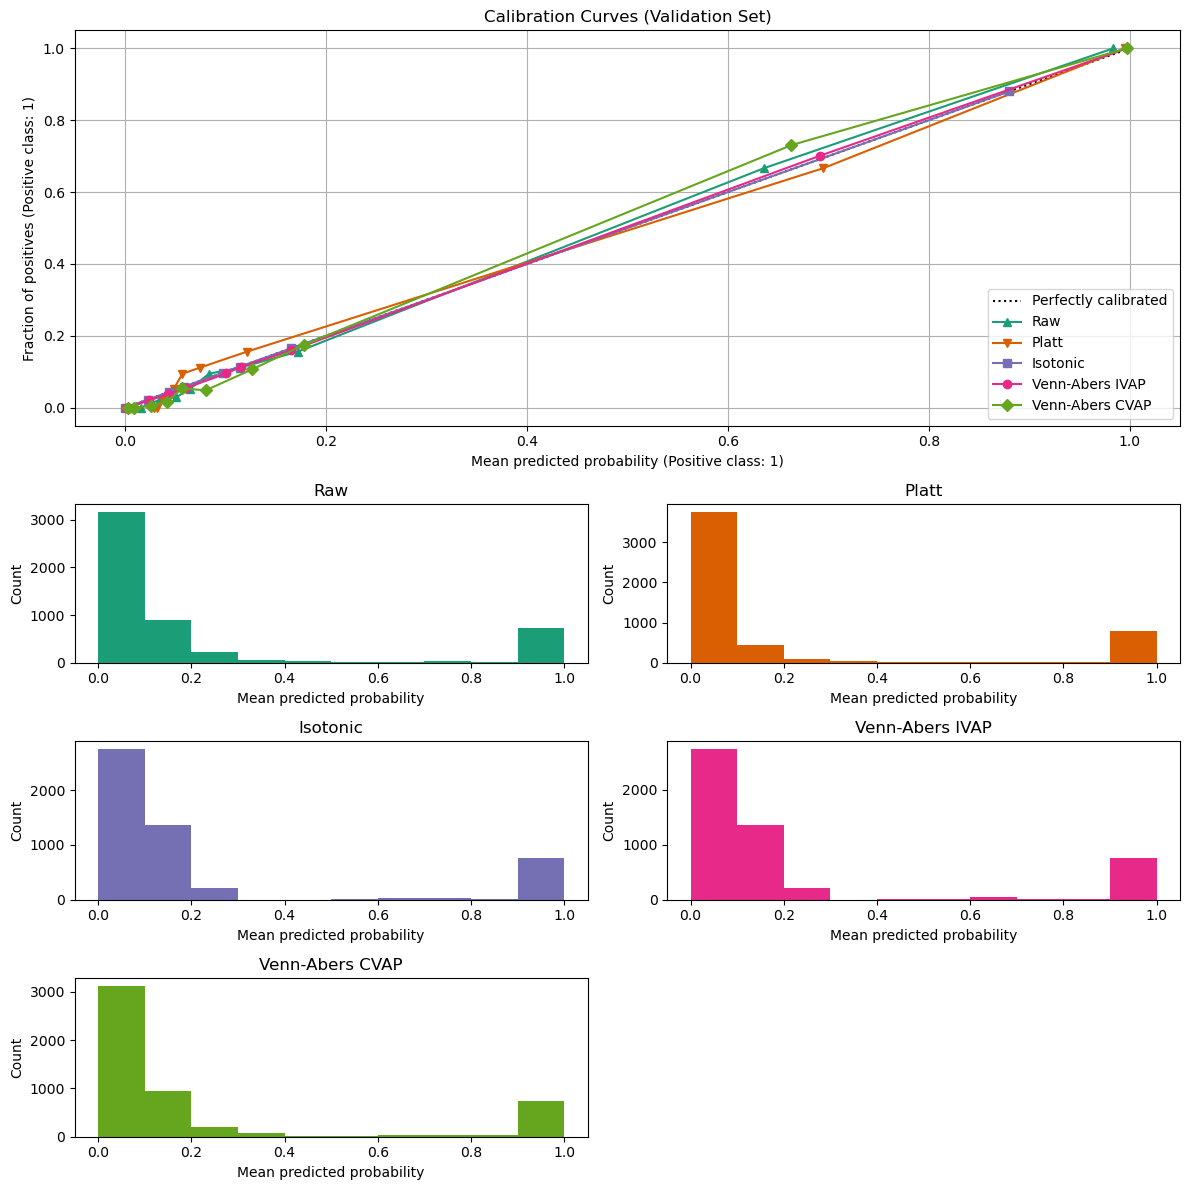

In [104]:
#######################################################################################
############################# Validation Set ################################################
#######################################################################################

results = []
results.append(calibration_metrics(y_va, proba_va,      "Raw (Uncalibrated)"))
results.append(calibration_metrics(y_va, proba_va_platt,    "Platt Scaling"))
results.append(calibration_metrics(y_va, proba_va_iso,      "Isotonic Regression"))
results.append(calibration_metrics(y_va, proba_val_iva,       "Venn-Abers (IVAP)"))
results.append(calibration_metrics(y_va, proba_val_cva,     "Venn-Abers (CVAP)"))

calib_df = pd.DataFrame(results).set_index("Method").round(4)
print("\nCalibration Performance (Validation Set):")
display(calib_df)



pred_list = [
    (proba_va, "Raw"),
    (proba_va_platt, "Platt"),
    (proba_va_iso, "Isotonic"),
    (proba_val_iva, "Venn-Abers IVAP"),
    (proba_val_cva, "Venn-Abers CVAP"),
]

# --- Start of Changes ---

fig = plt.figure(figsize=(12, 12)) # Increased height slightly for better layout
# GridSpec to 5 rows to make space for the 5th histogram
gs = GridSpec(5, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o", "D"]
for i, (pred, name) in enumerate(pred_list):
    show = CalibrationDisplay.from_predictions(
        y_va,
        pred,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
        strategy='quantile'
    )
    calibration_displays[name] = show

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves (Validation Set)")

# 2. Added the 5th coordinate for the "Venn-Abers CVAP" plot
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]

# --- End of Changes ---

for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [72]:
prob_val = pd.DataFrame({
    "ID": df_va[ID_COL],
    "Raw (Uncalibrated)": proba_va,
    "Platt Scaling": proba_va_platt,
    "Isotonic Regression": proba_va_iso,
    "Venn-Abers (IVAP)": proba_val_iva,
    "Venn-Abers (CVAP)": proba_val_cva,
    "loan_status": y_va
})

prob_test = pd.DataFrame({
    "ID": df_te[ID_COL],
    "Raw (Uncalibrated)": proba_te,
    "Platt Scaling": proba_te_platt,
    "Isotonic Regression": proba_te_iso,
    "Venn-Abers (IVAP)": proba_te_iva,
    "Venn-Abers (CVAP)": proba_te_cva,
    "loan_status": y_te
})

In [189]:
# prob_test['raw_bin'] = pd.cut(prob_test['Raw (Uncalibrated)'], bins=[-0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.01], labels=False)
# prob_test['iso_bin'] = pd.cut(prob_test['Isotonic Regression'], bins=[-0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.01], labels=False)
# prob_test['platt_bin'] = pd.cut(prob_test['Platt Scaling'], bins=[-0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.01], labels=False)
# prob_test['ivap_bin'] = pd.cut(prob_test['Venn-Abers (IVAP)'], bins=[-0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.01], labels=False)
# prob_test['cvap_bin'] = pd.cut(prob_test['Venn-Abers (CVAP)'], bins=[-0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.01], labels=False)

prob_test['raw_bin'] = pd.qcut(prob_test['Raw (Uncalibrated)'], q=10, labels=False, duplicates='drop')
prob_test['iso_bin'] = pd.qcut(prob_test['Isotonic Regression'], q=10, labels=False, duplicates='drop')
prob_test['platt_bin'] = pd.qcut(prob_test['Platt Scaling'], q=10, labels=False, duplicates='drop')
prob_test['ivap_bin'] = pd.qcut(prob_test['Venn-Abers (IVAP)'], q=10, labels=False, duplicates='drop')
prob_test['cvap_bin'] = pd.qcut(prob_test['Venn-Abers (CVAP)'], q=10, labels=False, duplicates='drop')

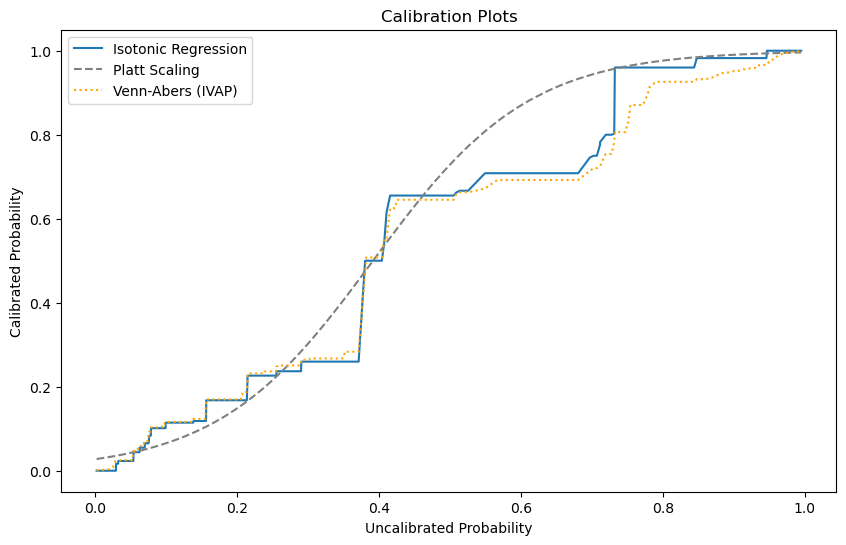

In [190]:
plt.figure(figsize=(10, 6))
plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Isotonic Regression'], label='Isotonic Regression')
plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Platt Scaling'], linestyle='--', color='gray', label='Platt Scaling')
plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Venn-Abers (IVAP)'], linestyle=':', color='orange', label='Venn-Abers (IVAP)')
# plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Venn-Abers (CVAP)'], linestyle='-.', color='purple', label='Venn-Abers (CVAP)')
plt.xlabel('Uncalibrated Probability')
plt.ylabel('Calibrated Probability')
plt.title('Calibration Plots')
plt.legend()
plt.show()

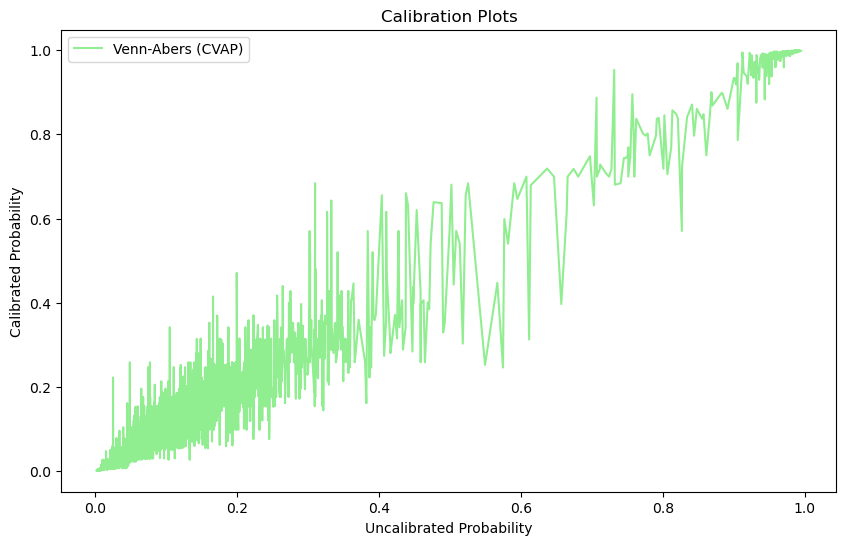

In [191]:
plt.figure(figsize=(10, 6))
plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Venn-Abers (CVAP)'],color='lightgreen', label='Venn-Abers (CVAP)')
plt.xlabel('Uncalibrated Probability')
plt.ylabel('Calibrated Probability')
plt.title('Calibration Plots')
plt.legend()
plt.show()

In [197]:
test_rates = prob_test.groupby('raw_bin')[['Raw (Uncalibrated)', 'Platt Scaling', 'Isotonic Regression', 'Venn-Abers (IVAP)', 'Venn-Abers (CVAP)', 'loan_status']].mean().reset_index()

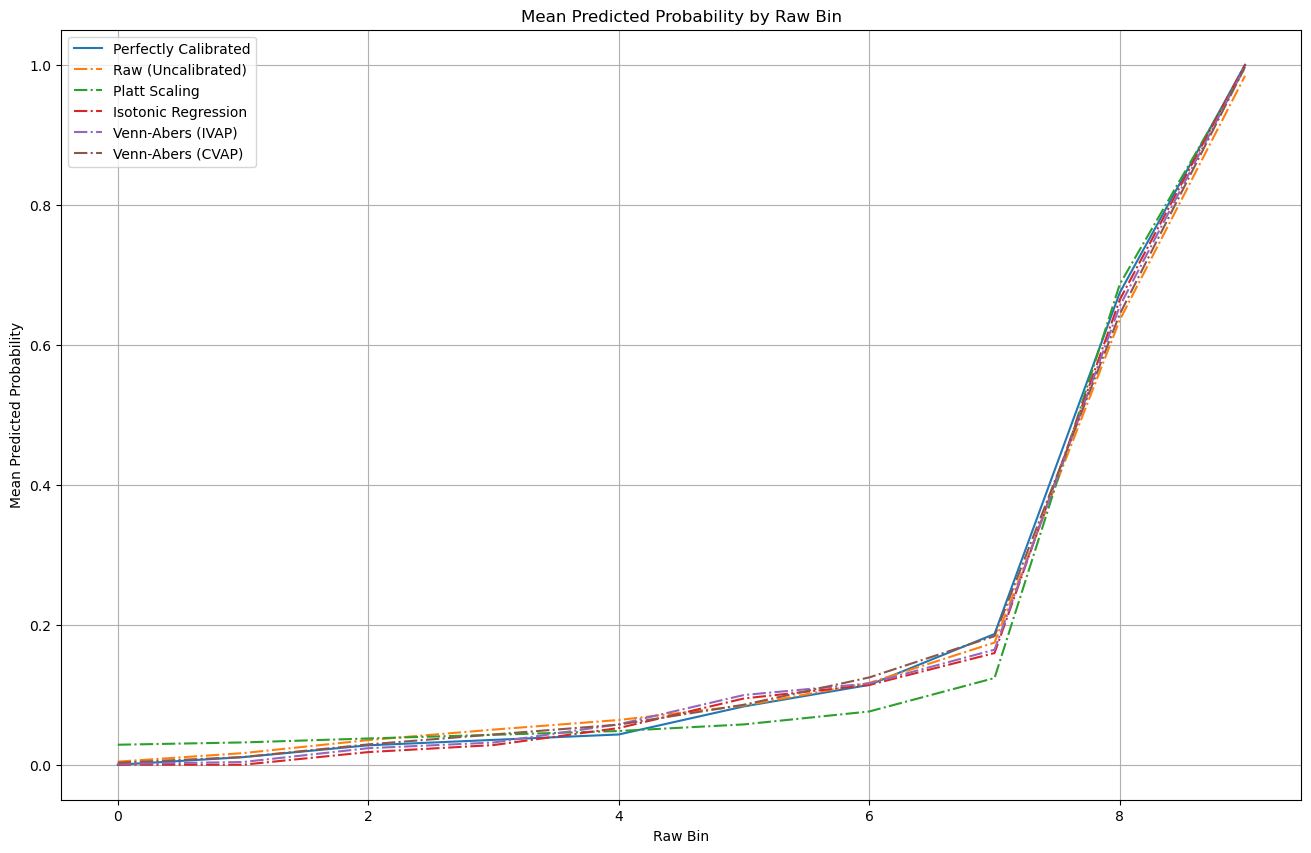

In [199]:
plt.figure(figsize=(16, 10))
plt.plot(test_rates['raw_bin'], test_rates['loan_status'], linestyle='-', label='Perfectly Calibrated')
plt.plot(test_rates['raw_bin'], test_rates['Raw (Uncalibrated)'], linestyle='dashdot',  label='Raw (Uncalibrated)')
plt.plot(test_rates['raw_bin'], test_rates['Platt Scaling'], linestyle='dashdot',  label='Platt Scaling')
plt.plot(test_rates['raw_bin'], test_rates['Isotonic Regression'], linestyle='dashdot', label='Isotonic Regression')
plt.plot(test_rates['raw_bin'], test_rates['Venn-Abers (IVAP)'], linestyle='dashdot', label='Venn-Abers (IVAP)')
plt.plot(test_rates['raw_bin'], test_rates['Venn-Abers (CVAP)'], linestyle='dashdot', label='Venn-Abers (CVAP)')
plt.xlabel('Raw Bin')
plt.ylabel('Mean Predicted Probability')
plt.title('Mean Predicted Probability by Raw Bin')
plt.legend()
plt.grid()
plt.show()

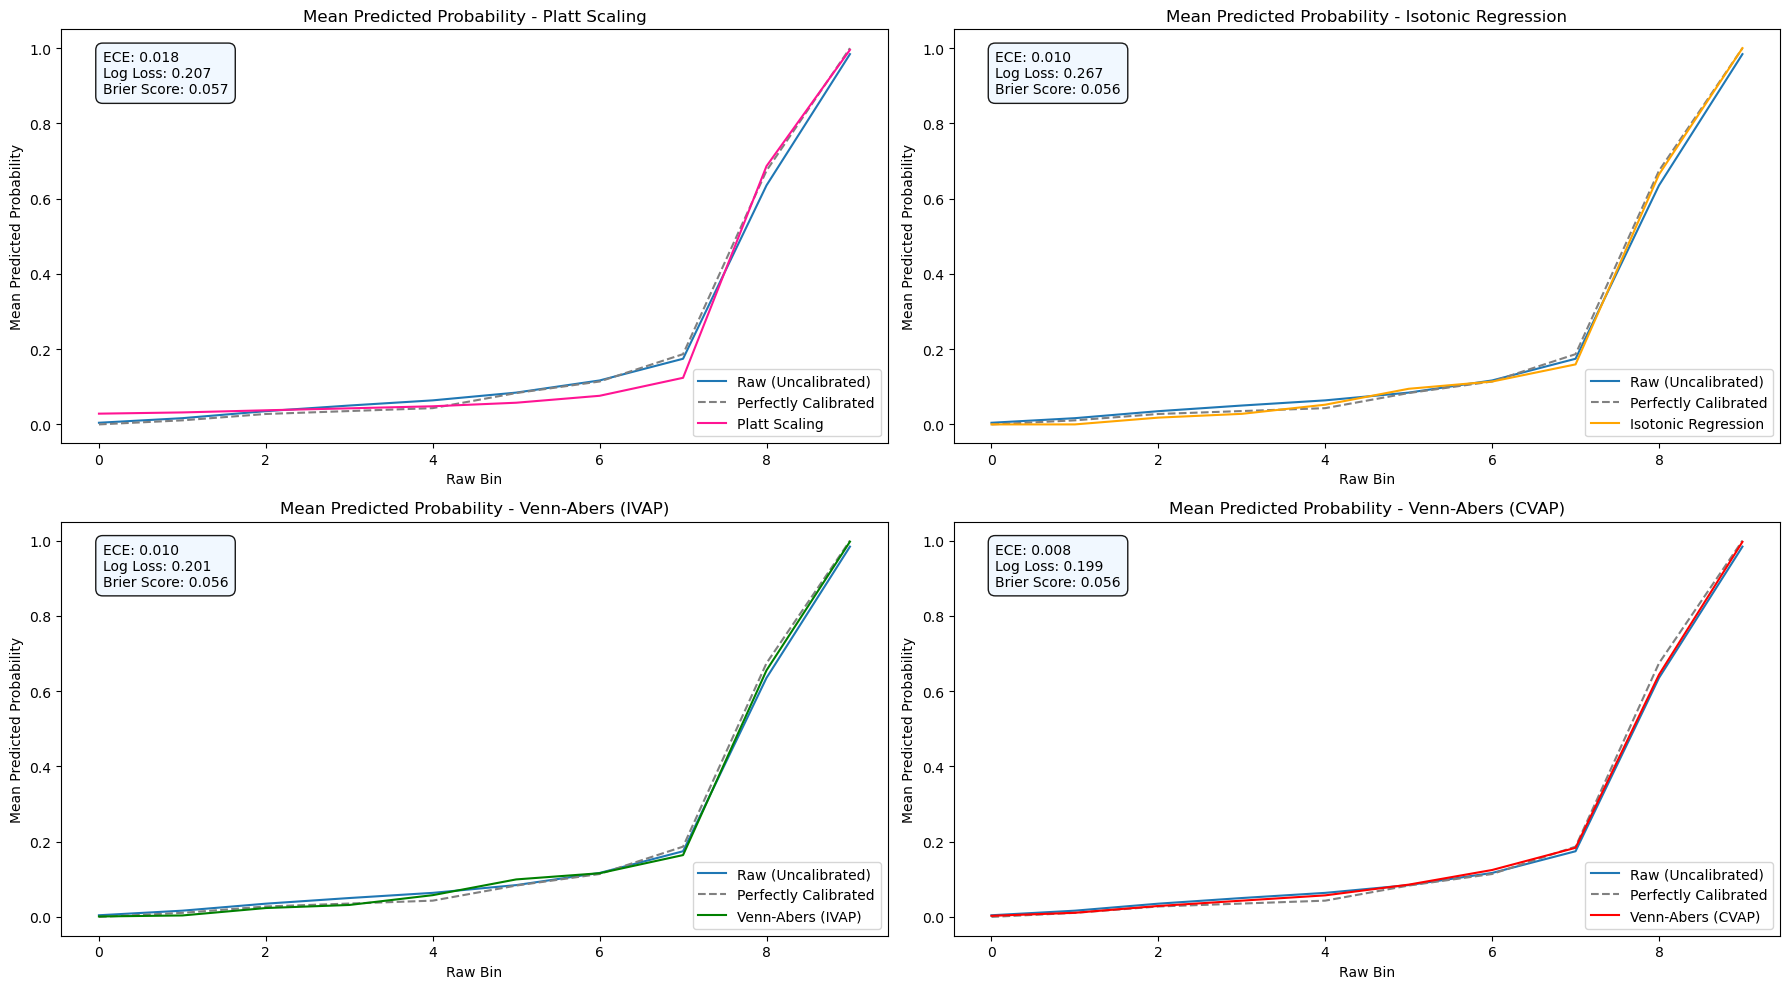

In [227]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
axs = axs.flatten()
colors = ['deeppink', 'orange', 'green', 'red']

for i, col in enumerate(['Platt Scaling', 'Isotonic Regression', 'Venn-Abers (IVAP)', 'Venn-Abers (CVAP)']):
    axs[i].plot(test_rates['raw_bin'], test_rates['Raw (Uncalibrated)'], linestyle='-', label='Raw (Uncalibrated)')
    axs[i].plot(test_rates['raw_bin'], test_rates['loan_status'], linestyle='--', label='Perfectly Calibrated', color='gray')
    axs[i].plot(test_rates['raw_bin'], test_rates[col], linestyle='-', label=col, color=colors[i])
    axs[i].set_xlabel('Raw Bin')
    axs[i].set_ylabel('Mean Predicted Probability')
    axs[i].set_title(f'Mean Predicted Probability - {col}')
    axs[i].legend()

    # --- Start of Improved Section ---
    
    # Calculate metrics
    ece = expected_calibration_error(prob_test['loan_status'], prob_test[col], num_bins=10, split_strategy='quantile')
    logloss = log_loss(prob_test['loan_status'], prob_test[col])
    brier = brier_score_loss(prob_test['loan_status'], prob_test[col])
    
    # Create a single, multi-line string for the metrics
    metrics_text = (f'ECE: {ece:.3f}\n'
                    f'Log Loss: {logloss:.3f}\n'
                    f'Brier Score: {brier:.3f}')
    
    # Define style for the text box
    bbox_props = dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.9)
    
    # Place the text box in the top-left corner of the subplot
    axs[i].text(0.05, 0.95, metrics_text, transform=axs[i].transAxes,
                fontsize=10, verticalalignment='top', bbox=bbox_props)

    # --- End of Improved Section ---

plt.tight_layout()
plt.show()

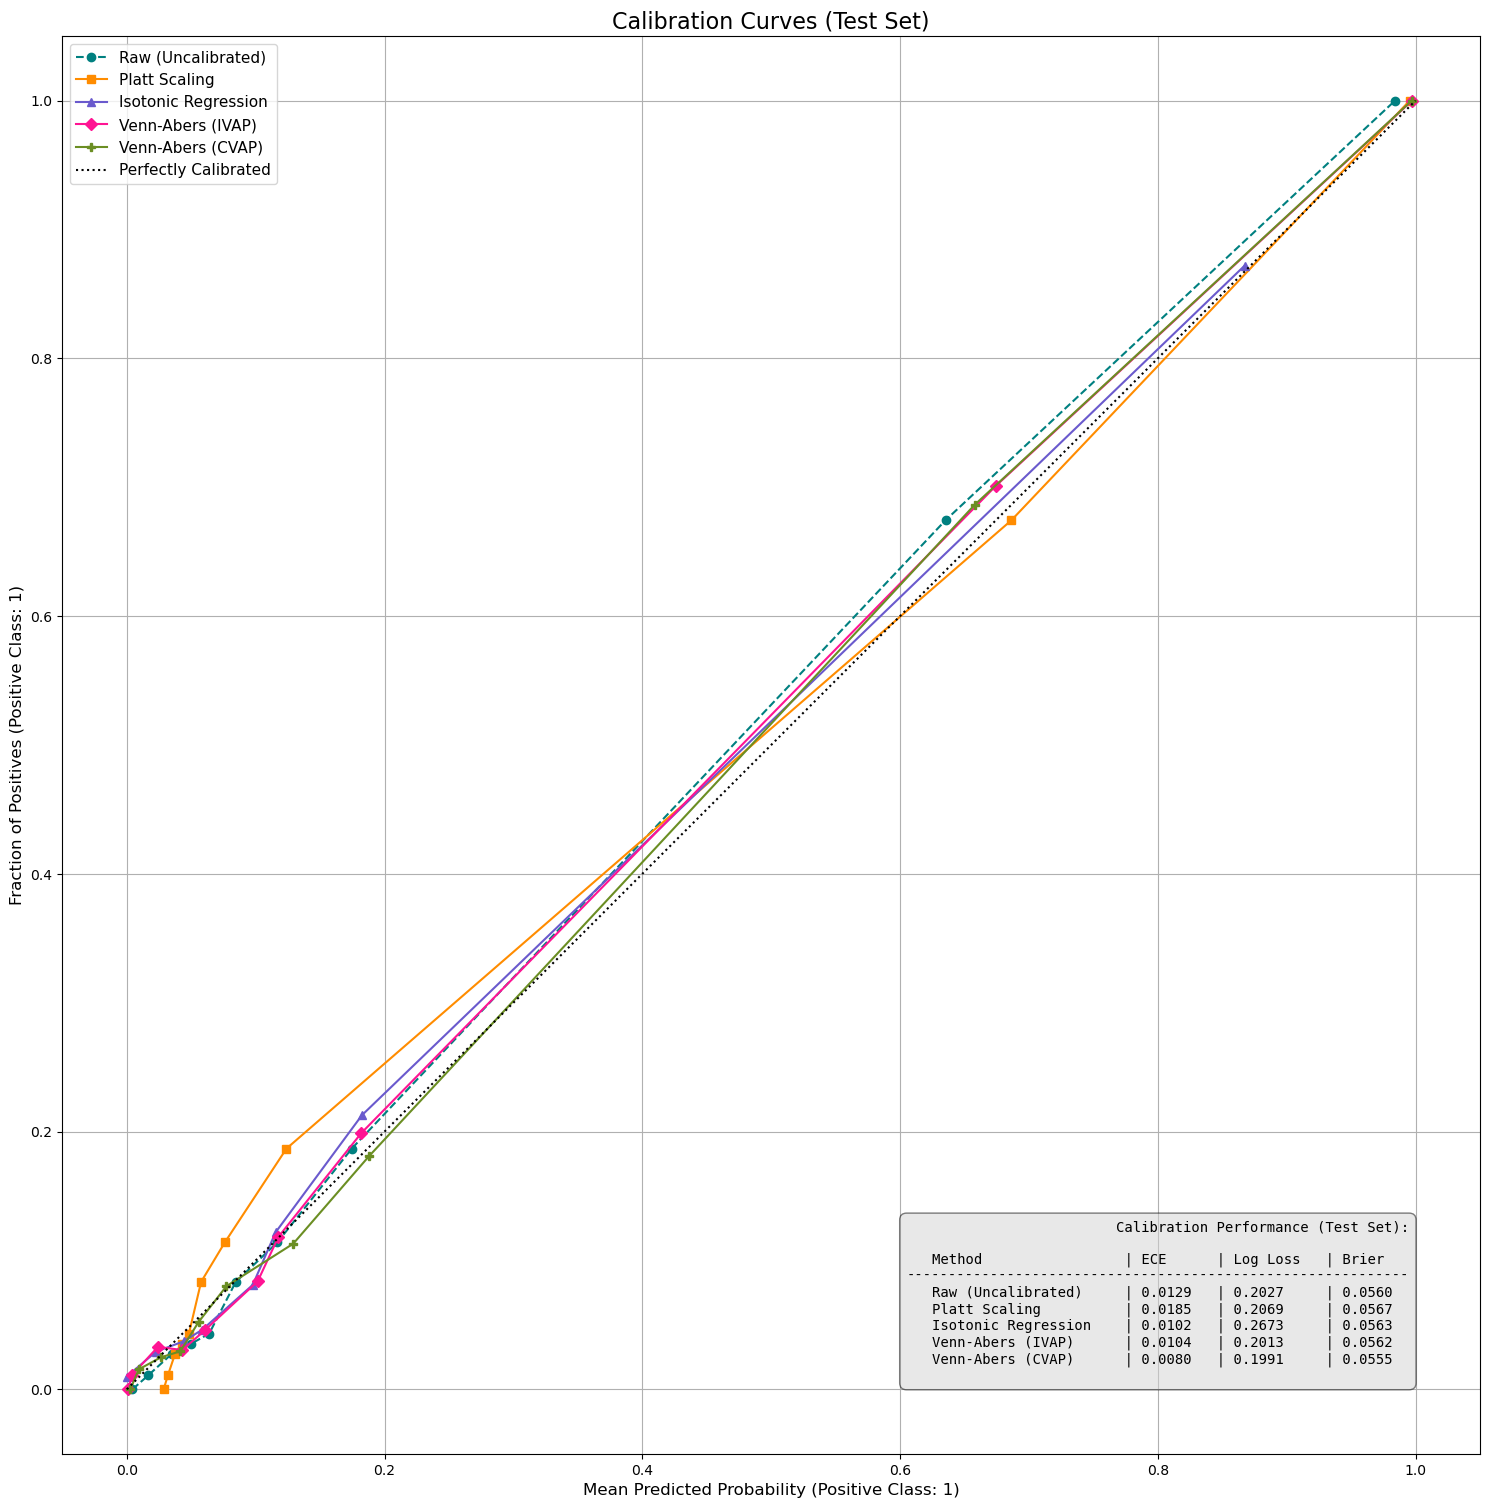

In [ ]:
fig, ax = plt.subplots(figsize=(15,20))

# --- 1. Define models, colors, and markers for clarity ---
models_to_plot = {
    'Raw (Uncalibrated)': {'color': 'teal', 'marker': 'o', 'linestyle': '--'},
    'Platt Scaling': {'color': 'darkorange', 'marker': 's', 'linestyle': '-'},
    'Isotonic Regression': {'color': 'slateblue', 'marker': '^', 'linestyle': '-'},
    'Venn-Abers (IVAP)': {'color': 'deeppink', 'marker': 'D', 'linestyle': '-'},
    'Venn-Abers (CVAP)': {'color': 'olivedrab', 'marker': 'P', 'linestyle': '-'}
}

metrics_summary = "Calibration Performance (Test Set):\n\n"
metrics_summary += f"{'Method':<22} | {'ECE':<8} | {'Log Loss':<10} | {'Brier':<8}\n"
metrics_summary += "-"*60 + "\n"

# --- 2. Loop to plot each calibration curve and collect metrics ---
for name, style in models_to_plot.items():
    y_true = prob_test['loan_status']
    y_prob = prob_test[name]
    
    # Calculate standard reliability diagram points
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_prob, n_bins=10, strategy='quantile'
    )
    
    # Plot the curve
    ax.plot(mean_predicted_value, fraction_of_positives, 
            marker=style['marker'], linestyle=style['linestyle'], label=name, color=style['color'])

    # Calculate metrics for the summary table
    ece = expected_calibration_error(y_true, y_prob, num_bins=10, split_strategy='quantile') # Using quantile for ECE as well for consistency
    logloss = log_loss(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    metrics_summary += f"{name:<22} | {ece:<8.4f} | {logloss:<10.4f} | {brier:<8.4f}\n"

# --- 3. Add the "Perfectly Calibrated" line and plot details ---
ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
ax.set_title('Calibration Curves (Test Set)', fontsize=16)
ax.set_xlabel('Mean Predicted Probability (Positive Class: 1)', fontsize=12)
ax.set_ylabel('Fraction of Positives (Positive Class: 1)', fontsize=12)
ax.grid(True)
ax.legend(loc='upper left', fontsize=11)
ax.set_aspect('equal') # Makes the plot square for better diagonal comparison

# --- 4. Add the consolidated metrics box ---
bbox_props = dict(boxstyle='round,pad=0.5', fc='lightgray', alpha=0.5)
ax.text(0.95, 0.05, metrics_summary, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props,
        fontname='monospace') # Monospace font for table alignment

plt.tight_layout()
plt.show()

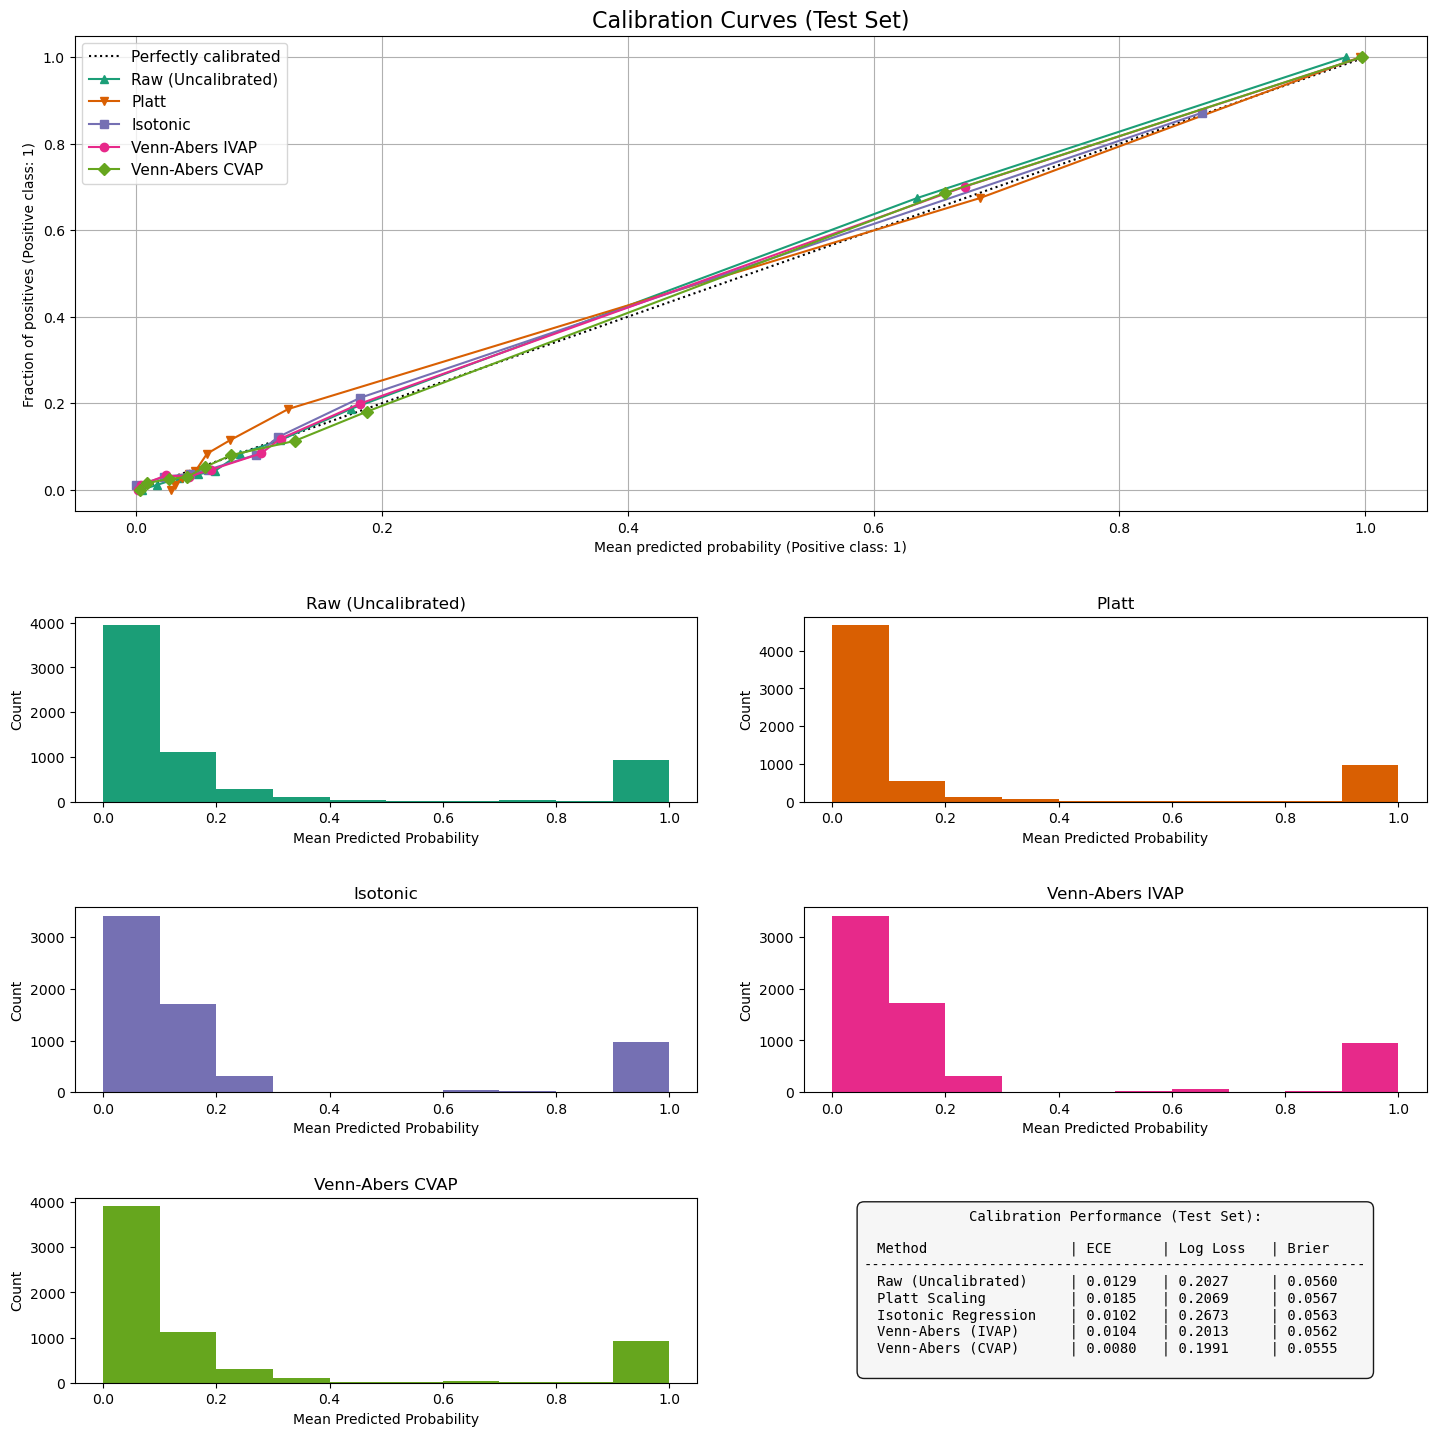

In [232]:
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
# from sklearn.calibration import CalibrationDisplay
# from sklearn.metrics import brier_score_loss, log_loss
# Assuming 'prob_test' DataFrame and 'expected_calibration_error' are loaded

# --- Setup remains the same ---
pred_list = [
    ("Raw (Uncalibrated)", "Raw (Uncalibrated)"), # Using column name for consistency
    ("Platt Scaling", "Platt"),
    ("Isotonic Regression", "Isotonic"),
    ("Venn-Abers (IVAP)", "Venn-Abers IVAP"),
    ("Venn-Abers (CVAP)", "Venn-Abers CVAP"),
]

fig = plt.figure(figsize=(15, 15)) # Made figure a bit wider
gs = GridSpec(5, 2, figure=fig)
colors = plt.get_cmap("Dark2")
markers = ["^", "v", "s", "o", "D"]

# --- NEW: Pre-calculate metrics and format them into a table string ---
metrics_summary = "Calibration Performance (Test Set):\n\n"
metrics_summary += f"{'Method':<22} | {'ECE':<8} | {'Log Loss':<10} | {'Brier':<8}\n"
metrics_summary += "-" * 60 + "\n"

for col_name, _ in pred_list:
    y_true = prob_test['loan_status']
    y_prob = prob_test[col_name]
    
    ece = expected_calibration_error(y_true, y_prob, num_bins=10, split_strategy='quantile')
    logloss = log_loss(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    
    # Use the shorter name for the table if you prefer
    display_name = col_name.split(' ')[0] if '(' in col_name else col_name 
    metrics_summary += f"{col_name:<22} | {ece:<8.4f} | {logloss:<10.4f} | {brier:<8.4f}\n"

# --- Calibration curve plot remains the same ---
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (col_name, name) in enumerate(pred_list):
    display = CalibrationDisplay.from_predictions(
        prob_test['loan_status'],
        prob_test[col_name],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
        strategy="quantile"
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves (Test Set)", fontsize=16)
ax_calibration_curve.legend(fontsize=11)

# --- Histograms plots remain the same ---
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]
for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean Predicted Probability", ylabel="Count")

# --- NEW: Add the metrics table to the empty subplot space ---
ax_table = fig.add_subplot(gs[4, 1])
ax_table.axis('off') # Turn off the axis lines and labels

bbox_props = dict(boxstyle='round,pad=0.5', fc='whitesmoke', alpha=0.9)
ax_table.text(0.5, 0.5, metrics_summary, 
              ha='center', 
              va='center', 
              fontsize=10, 
              fontname='monospace', # Monospace font for table alignment
              bbox=bbox_props)

plt.tight_layout(pad=3.0) # Adjust padding to ensure titles don't overlap
plt.show()

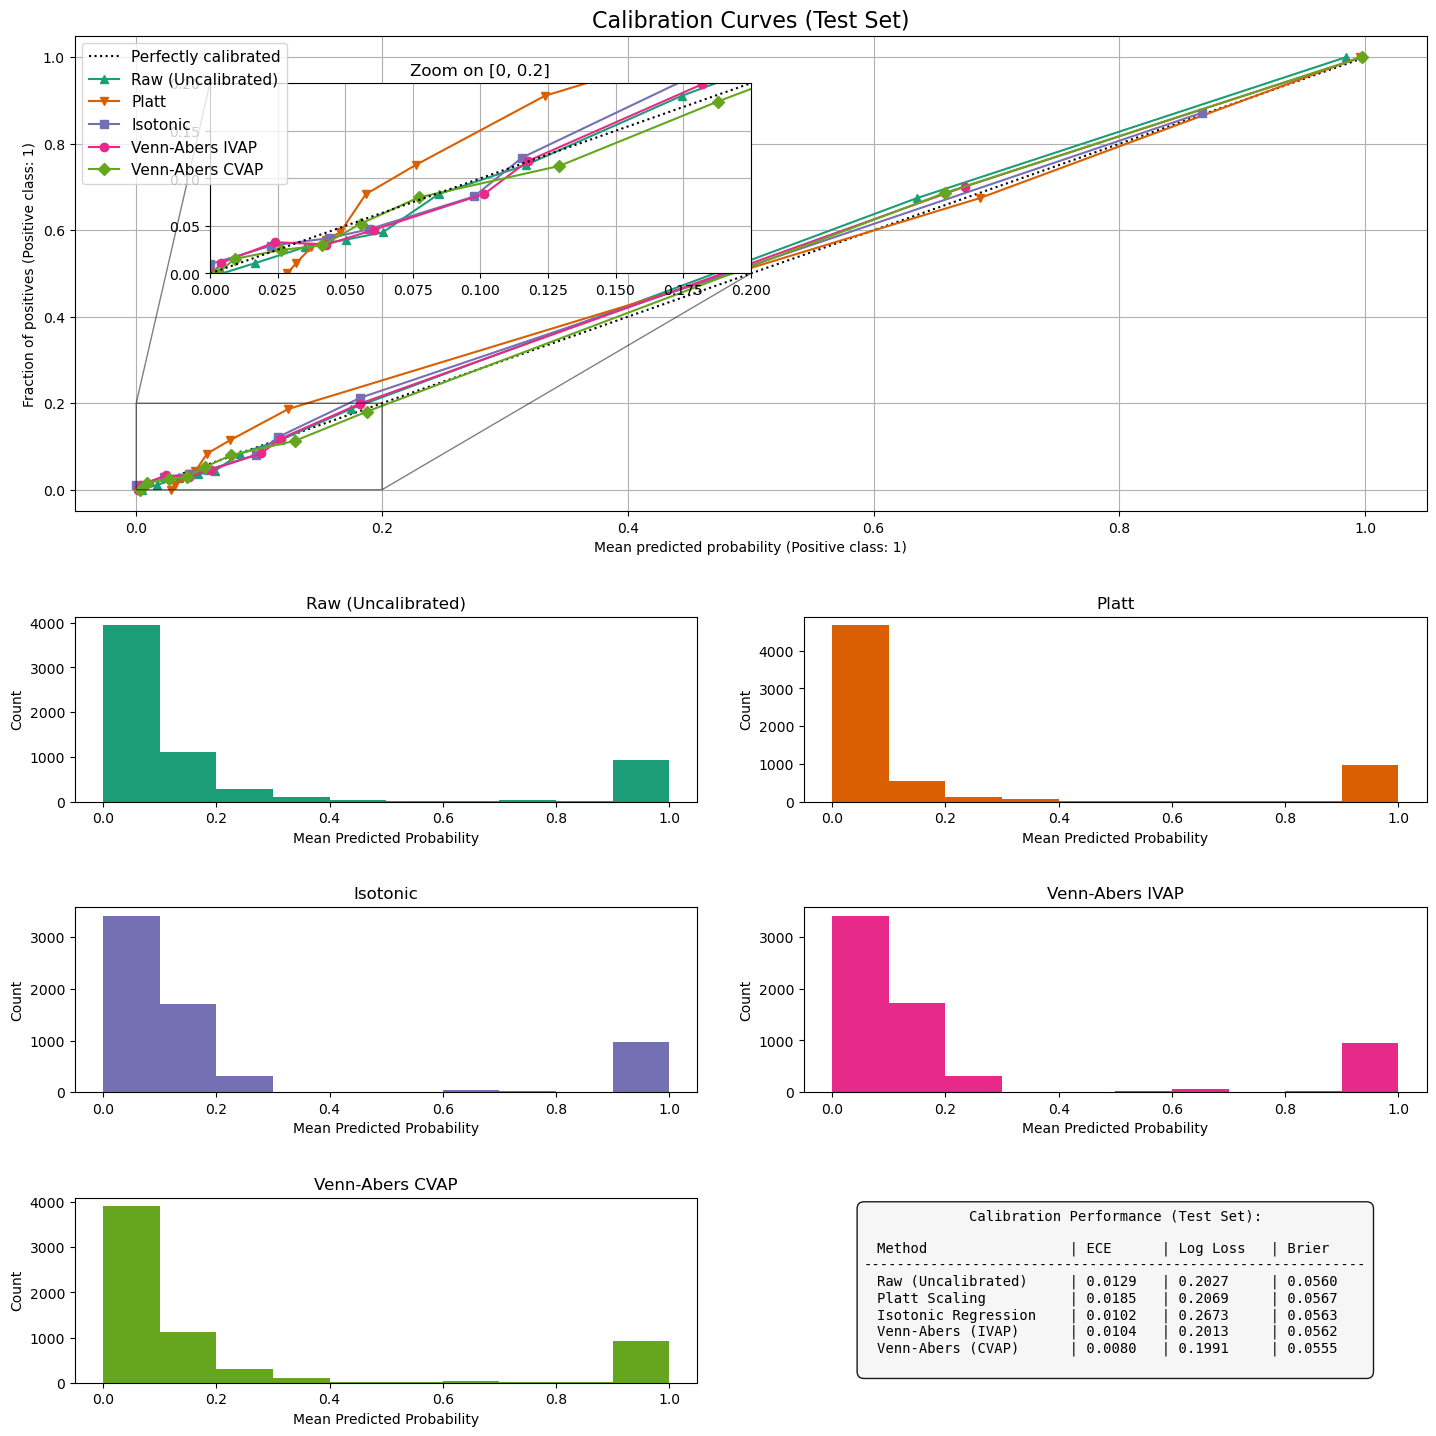

In [236]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss, log_loss
# Assuming 'prob_test' DataFrame and 'expected_calibration_error' are loaded

# --- Setup ---
pred_list = [
    ("Raw (Uncalibrated)", "Raw (Uncalibrated)"),
    ("Platt Scaling", "Platt"),
    ("Isotonic Regression", "Isotonic"),
    ("Venn-Abers (IVAP)", "Venn-Abers IVAP"),
    ("Venn-Abers (CVAP)", "Venn-Abers CVAP"),
]

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 2, figure=fig)
colors = plt.get_cmap("Dark2")
markers = ["^", "v", "s", "o", "D"]

# --- Metrics Table String ---
metrics_summary = "Calibration Performance (Test Set):\n\n"
metrics_summary += f"{'Method':<22} | {'ECE':<8} | {'Log Loss':<10} | {'Brier':<8}\n"
metrics_summary += "-" * 60 + "\n"
for col_name, _ in pred_list:
    y_true = prob_test['loan_status']
    y_prob = prob_test[col_name]
    ece = expected_calibration_error(y_true, y_prob, num_bins=10, split_strategy='quantile')
    logloss = log_loss(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    metrics_summary += f"{col_name:<22} | {ece:<8.4f} | {logloss:<10.4f} | {brier:<8.4f}\n"

# --- Main Calibration Curve Plot ---
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (col_name, name) in enumerate(pred_list):
    display = CalibrationDisplay.from_predictions(
        prob_test['loan_status'], prob_test[col_name], n_bins=10, name=name,
        ax=ax_calibration_curve, color=colors(i), marker=markers[i], strategy="quantile"
    )
    calibration_displays[name] = display
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves (Test Set)", fontsize=16)
ax_calibration_curve.legend(fontsize=11)

# --- NEW: Add the inset plot for a zoomed-in view ---
# Create an inset axes in the upper left corner of the main plot
ax_inset = ax_calibration_curve.inset_axes([0.1, 0.5, 0.4, 0.4])

# Re-plot all the calibration curves on the inset axes
for i, (col_name, name) in enumerate(pred_list):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        prob_test['loan_status'], prob_test[col_name], n_bins=10, strategy='quantile'
    )
    ax_inset.plot(mean_predicted_value, fraction_of_positives, marker=markers[i],
                  linestyle='-', color=colors(i))

# Add the diagonal line and set the zoomed limits
ax_inset.plot([0, 1], [0, 1], "k:")
ax_inset.set_xlim(0, 0.2)
ax_inset.set_ylim(0, 0.2)
ax_inset.set_title("Zoom on [0, 0.2]")
ax_inset.grid(True)

# Add connector lines to show where the inset is from
ax_calibration_curve.indicate_inset_zoom(ax_inset, edgecolor="black")
# --- End of New Section ---

# --- Histograms Plots ---
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]
for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(calibration_displays[name].y_prob, range=(0, 1), bins=10,
            label=name, color=colors(i))
    ax.set(title=name, xlabel="Mean Predicted Probability", ylabel="Count")

# --- Metrics Table Plot ---
ax_table = fig.add_subplot(gs[4, 1])
ax_table.axis('off')
bbox_props = dict(boxstyle='round,pad=0.5', fc='whitesmoke', alpha=0.9)
ax_table.text(0.5, 0.5, metrics_summary, ha='center', va='center',
              fontsize=10, fontname='monospace', bbox=bbox_props)

plt.tight_layout(pad=3.0)
plt.show()

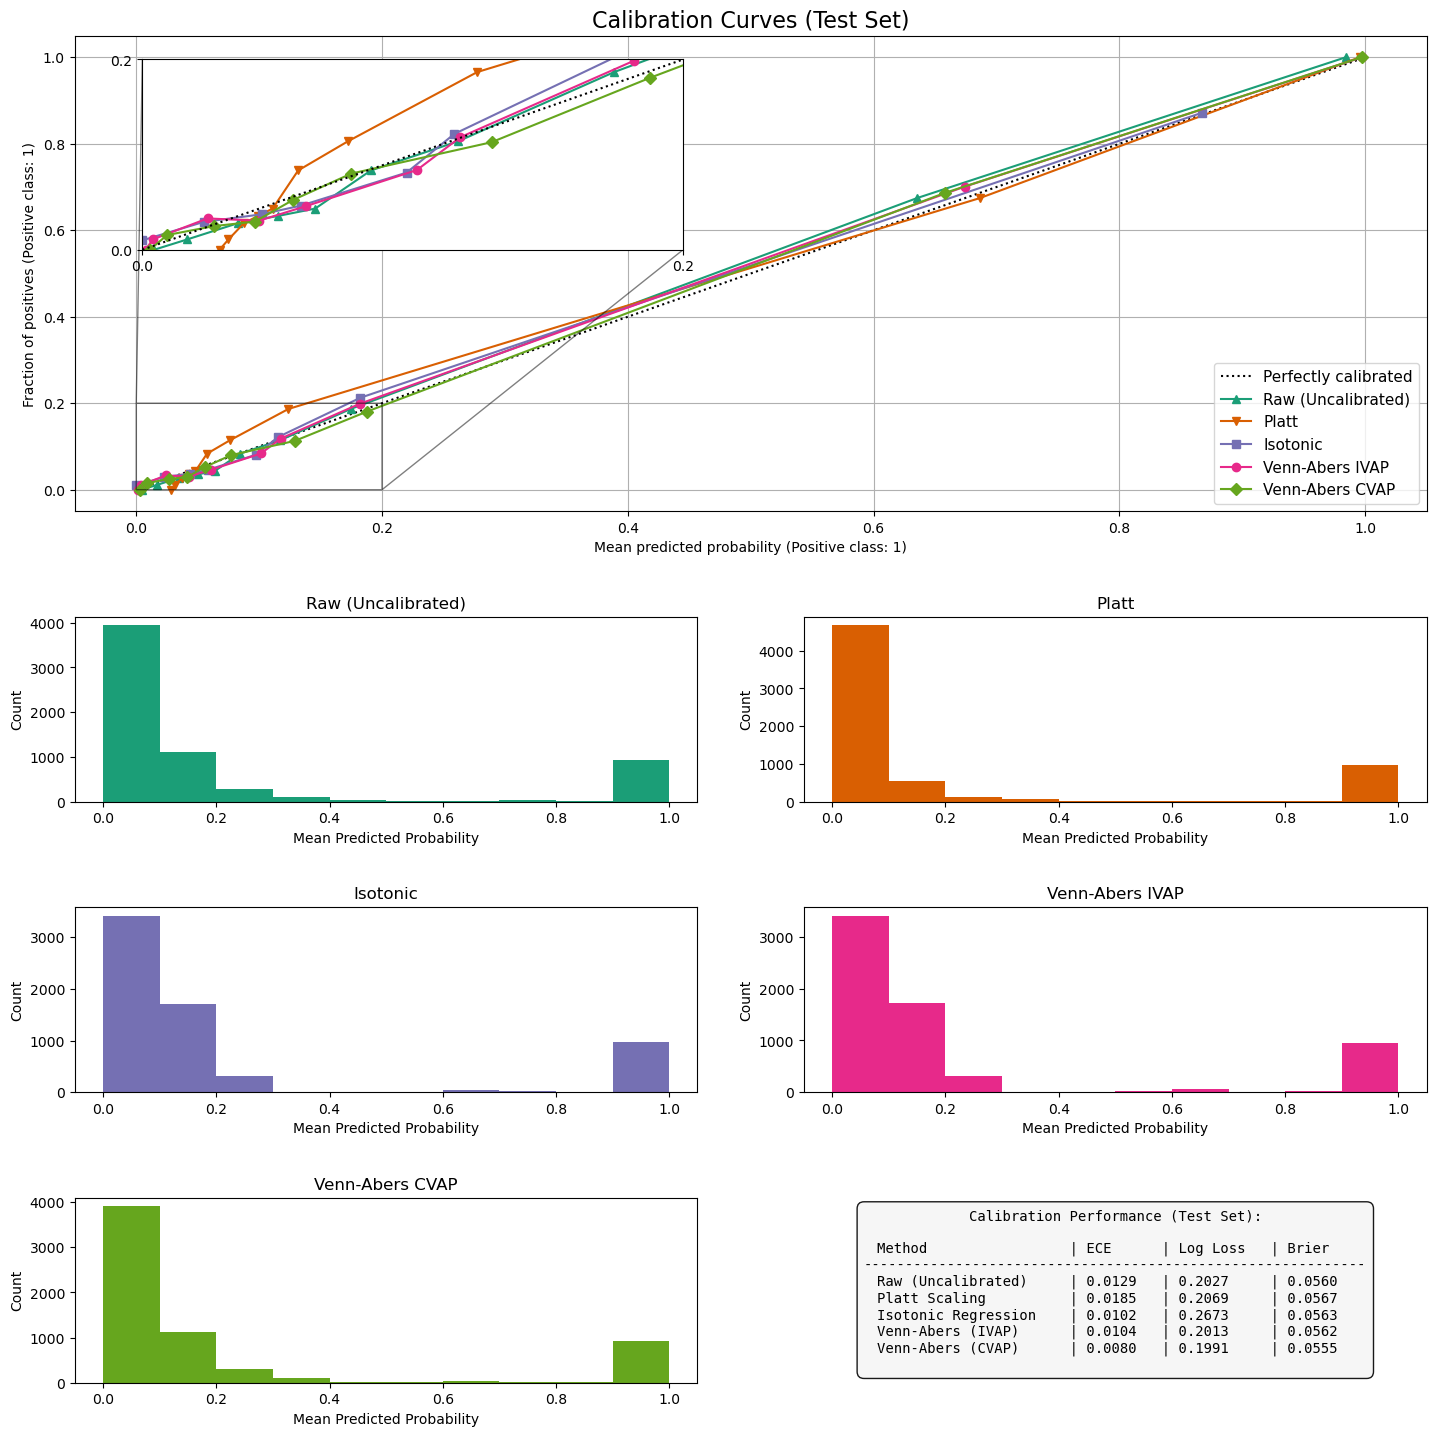

In [250]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss, log_loss
# Assuming 'prob_test' DataFrame and 'expected_calibration_error' are loaded

# --- Setup ---
pred_list = [
    ("Raw (Uncalibrated)", "Raw (Uncalibrated)"),
    ("Platt Scaling", "Platt"),
    ("Isotonic Regression", "Isotonic"),
    ("Venn-Abers (IVAP)", "Venn-Abers IVAP"),
    ("Venn-Abers (CVAP)", "Venn-Abers CVAP"),
]

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 2, figure=fig)
colors = plt.get_cmap("Dark2")
markers = ["^", "v", "s", "o", "D"]

# --- Metrics Table String ---
metrics_summary = "Calibration Performance (Test Set):\n\n"
metrics_summary += f"{'Method':<22} | {'ECE':<8} | {'Log Loss':<10} | {'Brier':<8}\n"
metrics_summary += "-" * 60 + "\n"
for col_name, _ in pred_list:
    y_true = prob_test['loan_status']
    y_prob = prob_test[col_name]
    ece = expected_calibration_error(y_true, y_prob, num_bins=10, split_strategy='quantile')
    logloss = log_loss(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    metrics_summary += f"{col_name:<22} | {ece:<8.4f} | {logloss:<10.4f} | {brier:<8.4f}\n"

# --- Main Calibration Curve Plot ---
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (col_name, name) in enumerate(pred_list):
    display = CalibrationDisplay.from_predictions(
        prob_test['loan_status'], prob_test[col_name], n_bins=10, name=name,
        ax=ax_calibration_curve, color=colors(i), marker=markers[i], strategy="quantile"
    )
    calibration_displays[name] = display
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves (Test Set)", fontsize=16)

# --- ADJUSTMENT 1: Move legend to the bottom-right ---
ax_calibration_curve.legend(loc='lower right', fontsize=11)

# --- ADJUSTMENT 2: Move inset plot to the top-left ---
ax_inset = ax_calibration_curve.inset_axes([0.05, 0.55, 0.4, 0.4])

# Re-plot all the calibration curves on the inset axes
for i, (col_name, name) in enumerate(pred_list):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        prob_test['loan_status'], prob_test[col_name], n_bins=10, strategy='quantile'
    )
    ax_inset.plot(mean_predicted_value, fraction_of_positives, marker=markers[i],
                  linestyle='-', color=colors(i))

# Add the diagonal line and set the zoomed limits
ax_inset.plot([0, 1], [0, 1], "k:")
ax_inset.set_xticks([0, 0.2])
ax_inset.set_yticks([0, 0.2])
ax_inset.set_xlim(0, 0.2)
ax_inset.set_ylim(0, 0.2)
# ax_inset.set_title("Zoom on [0, 0.2]")
# ax_inset.grid(True)
ax_calibration_curve.indicate_inset_zoom(ax_inset, edgecolor="black")

# --- Histograms and Table Plots (No changes needed below) ---
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]
for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(calibration_displays[name].y_prob, range=(0, 1), bins=10,
            label=name, color=colors(i))
    ax.set(title=name, xlabel="Mean Predicted Probability", ylabel="Count")

ax_table = fig.add_subplot(gs[4, 1])
ax_table.axis('off')
bbox_props = dict(boxstyle='round,pad=0.5', fc='whitesmoke', alpha=0.9)
ax_table.text(0.5, 0.5, metrics_summary, ha='center', va='center',
              fontsize=10, fontname='monospace', bbox=bbox_props)

plt.tight_layout(pad=3.0)
plt.show()

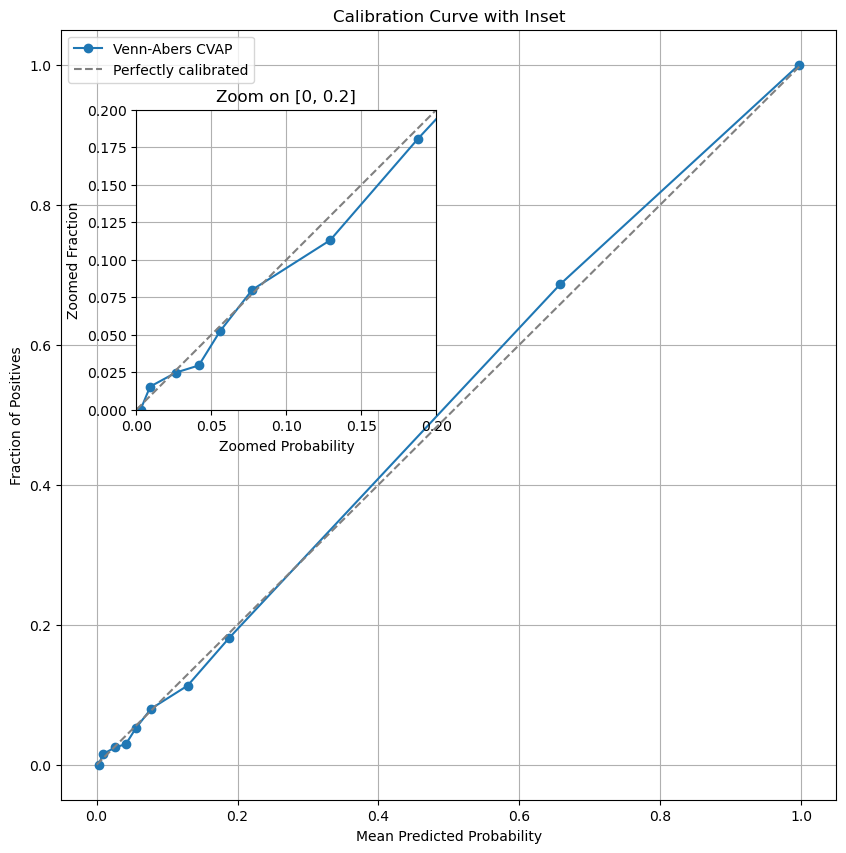

In [127]:
# Assuming 'y_te' and your predicted probabilities (e.g., 'proba_te_cva') are loaded

# --- Create the main plot first (as you already do) ---
fig, ax = plt.subplots(figsize=(10, 10))

# Example plot for one of your calibrators
prob_true, prob_pred = calibration_curve(y_te, proba_te_cva, n_bins=10, strategy='quantile')
ax.plot(prob_pred, prob_true, marker='o', label="Venn-Abers CVAP")
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfectly calibrated")

ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives")
ax.set_title("Calibration Curve with Inset")
ax.grid(True)
ax.legend()


# --- Add the inset axes ---
# These coordinates are [left, bottom, width, height] relative to the figure size
ax_inset = fig.add_axes([0.2, 0.5, 0.3, 0.3])

# Plot the same data on the inset axes
ax_inset.plot(prob_pred, prob_true, marker='o')
ax_inset.plot([0, 1], [0, 1], linestyle='--', color='gray')

# --- Set the zoom level for the inset ---
ax_inset.set_xlim(0, 0.2)
ax_inset.set_ylim(0, 0.2)
ax_inset.set_xlabel("Zoomed Probability")
ax_inset.set_ylabel("Zoomed Fraction")
ax_inset.set_title("Zoom on [0, 0.2]")
ax_inset.grid(True)

# Optional: Add lines to show where the zoom is coming from
# ax.indicate_inset_zoom(ax_inset, edgecolor="black")

plt.show()

# Save predictions

In [21]:
# --- Validation CSV ---
val_df = pd.DataFrame({
    "ID": df_va[ID_COL].values,
    "raw_prob": xgb_model.predict_proba(X_va)[:,1],
    "platt_prob": platt.predict_proba(X_va)[:,1],
    "isotonic_prob": isotonic.predict_proba(X_va)[:,1],
    "va_ind_prob": VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_cal, p0_p1_output=False)[:,1],
    "va_cross_prob": va_cross.predict_proba(X_va)[:,1],
})
val_df.to_csv("validation_calibration_outputs.csv", index=False)

# --- Test CSV ---
test_df = pd.DataFrame({
    "ID": df_te[ID_COL].values,
    "raw_prob": proba_raw,
    "platt_prob": proba_platt,
    "isotonic_prob": proba_iso,
    "va_ind_prob": p_va_ind,
    "va_cross_prob": p_va_cross,
})
test_df.to_csv("test_calibration_outputs.csv", index=False)
